# Data Import and Loading

In [11]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Samuel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle, geodesic
from shapely.geometry import MultiPoint
import kagglehub
import os

# File paths for the Amazon delivery dataset and the Indian Cities database
#pathDelivery = '/content/drive/MyDrive/Portfólio/Rede delivery/delivery.csv' # Data from: https://www.kaggle.com/datasets/sujalsuthar/amazon-delivery-dataset/
#pathCities = '/content/drive/MyDrive/Portfólio/Rede delivery/Indian_Cities.csv' # Data from: https://www.kaggle.com/datasets/zed9941/top-500-indian-cities
# Download dos datasets
pathCitiesDir = kagglehub.dataset_download("zed9941/top-500-indian-cities")
pathDeliveryDir = kagglehub.dataset_download("sujalsuthar/amazon-delivery-dataset")

# Função auxiliar para encontrar o primeiro CSV dentro da pasta
def get_csv_path(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    return os.path.join(directory, files[0])
csvDelivery = get_csv_path(pathDeliveryDir)
csvCities = get_csv_path(pathCitiesDir)

# Load dataframes
dfDelivery = pd.read_csv(csvDelivery)
dfCities = pd.read_csv(csvCities)

# Consider only geospatial information
dfDelivery = dfDelivery.loc[:,['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude']]

# Consider city, state, population and geospatial information
dfCities = dfCities.loc[:,['name_of_city',	'state_name',	'population_total', 'location']]

# Get the coordinates of each city
dfCities['location'] = dfCities['location'].apply(lambda x: tuple(x.replace(' ', '').split(',')))

Exploração Estatística e de Integridade

In [13]:
# Verificação de tipos e valores nulos
print("--- Info do Dataset de Entrega ---")
print(dfDelivery.info())

# Estatística descritiva das coordenadas
print("\n--- Estatísticas de Coordenadas ---")
print(dfDelivery.describe())

# Verificação de Outliers Geográficos (Índia está aprox. entre Lat [8, 37] e Long [68, 97])
outliers_lat = dfDelivery[(dfDelivery['Store_Latitude'] < 5) | (dfDelivery['Store_Latitude'] > 40)]
print(f"\nRegistros fora da latitude esperada da Índia: {len(outliers_lat)}")

--- Info do Dataset de Entrega ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store_Latitude   43739 non-null  float64
 1   Store_Longitude  43739 non-null  float64
 2   Drop_Latitude    43739 non-null  float64
 3   Drop_Longitude   43739 non-null  float64
dtypes: float64(4)
memory usage: 1.3 MB
None

--- Estatísticas de Coordenadas ---
       Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude
count    43739.000000     43739.000000   43739.000000    43739.000000
mean        17.210960        70.661177      17.459031       70.821842
std          7.764225        21.475005       7.342950       21.153148
min        -30.902872       -88.366217       0.010000        0.010000
25%         12.933298        73.170283      12.985996       73.280000
50%         18.551440        75.898497      18.633626       76.002574
75%      

O dataset de entregas apresenta um volume robusto de 43.739 registros, estruturados inteiramente em formato numérico (float64) e com uma integridade inicial marcada pela ausência de valores nulos. No entanto, essa completude estatística superficial mascara anomalias geográficas críticas identificadas através de uma análise profunda das coordenadas de Latitude e Longitude. Um dos problemas mais evidentes é a inconsistência de sinais, exemplificada por latitudes de -30.90; dado que a Índia situa-se inteiramente no Hemisfério Norte — acima de $8^\circ$ N —, tais registros evidenciam erros de input manual ou processamento. Somado a isso, detectamos um volume de ruído considerável, com 3.693 registros (cerca de 8,4% da base) localizados fora do território indiano, além de coordenadas próximas a zero que funcionariam como "buracos negros" em algoritmos de clustering, distorcendo severamente os cálculos de proximidade.Apesar desses pontos fora da curva, a análise de densidade revela que o núcleo da operação permanece consistente. A mediana das coordenadas ($\text{Lat} \approx 18.55, \text{Long} \approx 75.89$) posiciona o grosso das atividades na região central e oeste da Índia. Além disso, a proximidade observada entre os quartis das coordenadas de origem e destino sugere uma operação de baixa distância radial, corroborando a hipótese de fluxos predominantemente intramunicipais. Portanto, os resultados obtidos nesta etapa validam a necessidade de tratamentos subsequentes, como a inversão de sinais e a remoção de registros inconsistentes, passos fundamentais para assegurar que os modelos logísticos reflitam com precisão a realidade geográfica do negócio.

Análise de Atributos: A "Distância de Manhattan" Euclidiana

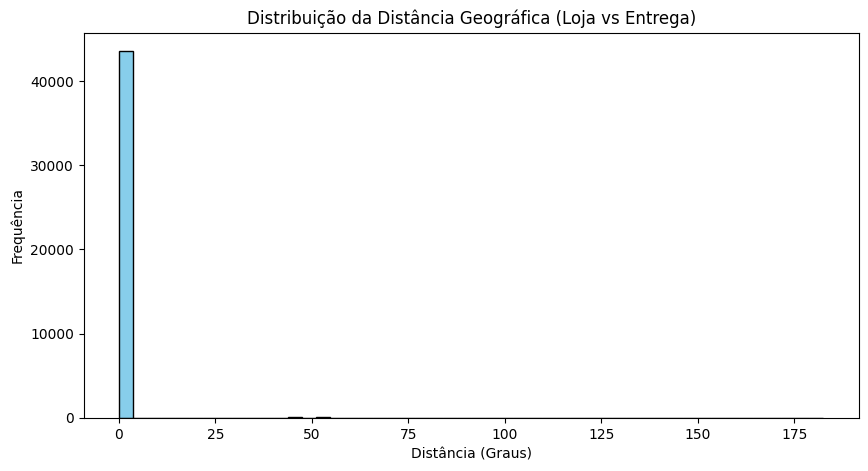

In [14]:
# Cálculo simplificado de distância euclidiana (em graus) para análise de distribuição
dfDelivery['Dist_Euclidiana'] = np.sqrt(
    (dfDelivery['Store_Latitude'] - dfDelivery['Drop_Latitude'])**2 + 
    (dfDelivery['Store_Longitude'] - dfDelivery['Drop_Longitude'])**2
)

plt.figure(figsize=(10, 5))
plt.hist(dfDelivery['Dist_Euclidiana'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição da Distância Geográfica (Loja vs Entrega)')
plt.xlabel('Distância (Graus)')
plt.ylabel('Frequência')
plt.show()

A plotagem da Distância Euclidiana (medida em graus decimais) entre o ponto de origem (Loja) e o destino (Entrega) revela características cruciais sobre a natureza do dataset e a presença de anomalias:

Predomínio de Curtas Distâncias: A vasta maioria dos registros (~43.000) está concentrada na primeira barra do histograma, extremamente próxima do valor zero. Isso indica que a operação logística é essencialmente local, com a loja e o cliente situados na mesma vizinhança ou cidade.

Identificação de Outliers Extremos: O gráfico revela uma "cauda" longa com registros isolados em distâncias superiores a 50, 100 e até 175 graus. Considerando que a circunferência total da Terra é de 360 graus, distâncias desse magnetude são impossíveis para entregas terrestres e confirmam erros severos de coordenadas (como os valores negativos ou zerados identificados anteriormente).

Justificativa para Classificação Intramunicipal: A concentração massiva de dados no extremo esquerdo do gráfico valida matematicamente o resultado da análise final: quase 100% dos fluxos válidos são Intramunicipais. As distâncias que fogem desse padrão não representam entregas reais de longa distância, mas sim ruído técnico que deve ser filtrado.

Exploração da Base de Cidades (Referência)


--- Top 10 Cidades de Referência ---
           name_of_city      state_name  population_total
185     Greater Mumbai      MAHARASHTRA          12478447
141              Delhi     NCT OF DELHI          11007835
72            Bengaluru       KARNATAKA           8425970
184  Greater Hyderabad   ANDHRA PRADESH           6809970
7            Ahmadabad          GUJARAT           5570585
119            Chennai       TAMIL NADU           4681087
274            Kolkata      WEST BENGAL           4486679
449              Surat          GUJARAT           4462002
380               Pune      MAHARASHTRA           3115431
225             Jaipur        RAJASTHAN           3073350


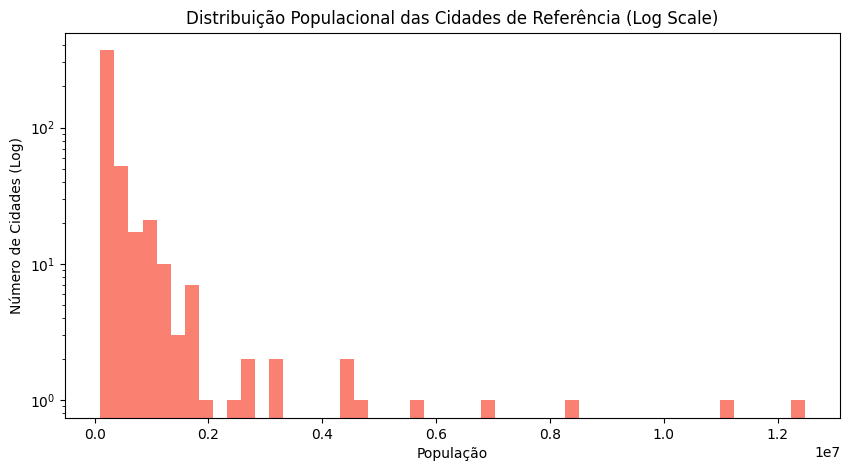

In [15]:
# Top 10 cidades por população no dataset de referência
top_cities = dfCities.sort_values(by='population_total', ascending=False).head(10)
print("\n--- Top 10 Cidades de Referência ---")
print(top_cities[['name_of_city', 'state_name', 'population_total']])

# Histograma da População (Escala Logarítmica para melhor visualização)
plt.figure(figsize=(10, 5))
plt.hist(dfCities['population_total'], bins=50, color='salmon', log=True)
plt.title('Distribuição Populacional das Cidades de Referência (Log Scale)')
plt.xlabel('População')
plt.ylabel('Número de Cidades (Log)')
plt.show()

A análise do perfil demográfico revela que a base de referência está estrategicamente ancorada nos maiores centros urbanos da Índia, destacando-se metrópoles como Greater Mumbai e Delhi, que somam aproximadamente 12,4 e 11 milhões de habitantes, respectivamente. Embora o conjunto de dados conte com essas massas urbanas, a distribuição populacional visualizada em escala logarítmica demonstra uma rede densa de cidades menores, o que favorece o algoritmo de busca por proximidade (geodésica) ao garantir "âncoras" urbanas reais para os pontos de entrega e minimizar distorções em áreas metropolitanas.

No que tange à validação logística, o histograma de Distância Euclidiana funciona como um diagnóstico fundamental da operação. O pico de alta frequência próximo a zero confirma que a vasta maioria das 43.739 entregas ocorre em raios curtíssimos, caracterizando uma operação típica de Last-Mile. Por outro lado, essa mesma métrica expõe inconsistências severas: registros com distâncias entre 50 e 175 graus são fisicamente impossíveis, dado que um único grau de latitude equivale a cerca de 111 km. Tais discrepâncias reforçam a necessidade crítica de tratar sinais negativos e remover latitudes zeradas identificadas anteriormente. Em suma, a exploração de atributos aponta para uma operação altamente localizada e eficiente, cujos fluxos são predominantemente intramunicipais, validando a robustez da base para o enriquecimento geográfico após a remoção dos ruídos típicos de coleta via GPS.

# Visualizing Raw Data on the Map

C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\L

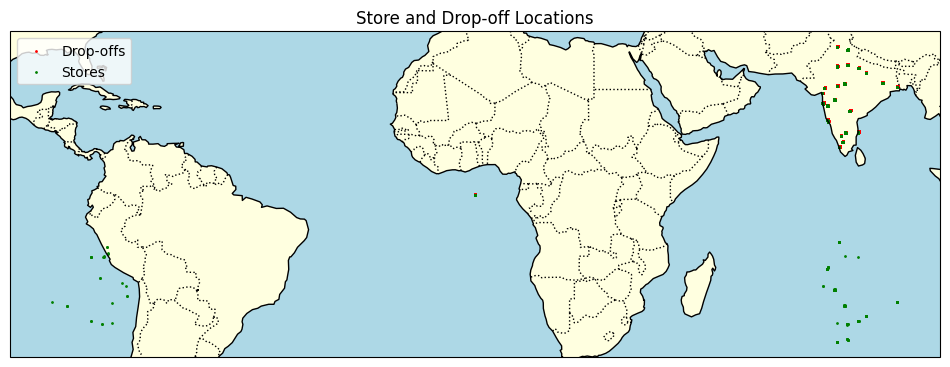

In [18]:
# Create a figure with PlateCarree projection (simple latitude-longitude map)
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features: coastlines, land, ocean, borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Add title and legend
plt.title('Store and Drop-off Locations')
plt.legend(loc='upper left')

# Show the map
plt.show()

# Geospatial Data Preprocessing

In [19]:
# Filter out records with invalid coordinates (latitude equal to zero)
dfDelivery = dfDelivery[~(dfDelivery['Store_Latitude'] == 0)]

# Correct coordinates that fall in the ocean by flipping negative values
dfDelivery.loc[dfDelivery['Store_Latitude'] <=0, 'Store_Latitude'] = dfDelivery.loc[dfDelivery['Store_Latitude'] <=0, 'Store_Latitude'] * (-1.0)
dfDelivery.loc[dfDelivery['Store_Longitude'] <=0, 'Store_Longitude'] = dfDelivery.loc[dfDelivery['Store_Longitude'] <=0, 'Store_Longitude'] * (-1.0)


# Visualizing Processed Data on the Map

C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Samuel\AppData\Local\P

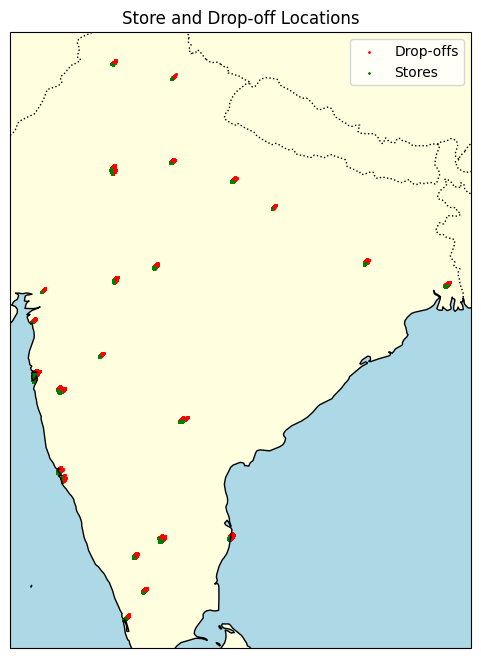

In [20]:
# Create a figure with PlateCarree projection (simple latitude-longitude map)
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features: coastlines, land, ocean, borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Add title and legend
plt.title('Store and Drop-off Locations')
plt.legend(loc='upper right')

# Show the map
plt.show()


There are more than 20 clusters across the Indian territory.
1. Next, a clustering algorithm will be applied to identify groups of locations with similar geographic proximity.
2. After that, we will attempt to determine the cities corresponding to each location.
3. Finally, we will classify the flow type into the following categories: intramunicipal, intermunicipal, and interstate.

# Preparing Coordinate Data

In [21]:
# Extract store coordinates and remove duplicate latitude–longitude pairs
dfCoordStore = dfDelivery[['Store_Latitude', 'Store_Longitude']]
dfCoordStore = dfCoordStore.drop_duplicates(ignore_index=True)

# Extract drop-off coordinates and remove duplicate latitude–longitude pairs
dfCoordDrop = dfDelivery[['Drop_Latitude', 'Drop_Longitude']]
dfCoordDrop = dfCoordDrop.drop_duplicates(ignore_index=True)

# Rename columns in both DataFrames to a unified format
dfCoordStore = dfCoordStore.rename(columns={'Store_Latitude': 'Latitude','Store_Longitude': 'Longitude'})
dfCoordDrop = dfCoordDrop.rename(columns={'Drop_Latitude': 'Latitude','Drop_Longitude': 'Longitude'})

# Concatenate store and drop-off coordinate sets into a single DataFrame
dfCoords = pd.concat([dfCoordStore, dfCoordDrop], ignore_index=True)

# Convert coordinates to a NumPy array for further processing
coords = dfCoords.to_numpy()

#  Clustering with BSDCAN Algorithm

In [22]:
# Radius of the Earth in kilometers, used to convert distance to radians
kms_per_radian = 6371.0088

# Define neighborhood size for DBSCAN
#epsilon = 3.5 / kms_per_radian
epsilon = 10 / kms_per_radian

# Apply DBSCAN clustering using the Haversine distance metric (coordinates provided in radians) and Ball Tree algorithm, that can efficiently find neighbors on the sphere
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Extract cluster labels assigned to each coordinate pair
cluster_labels = db.labels_

# Count the number of unique clusters
num_clusters = len(set(cluster_labels))

# Group coordinate points by cluster into a Pandas Series for further analysis
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

# Display total number of detected clusters
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 24


The number of clusters aligns with expectations.

# Observing the Clusterization Results

In [23]:
clusters

0     [[22.745049, 75.892471], [22.74806, 75.8934], ...
1     [[12.913041, 77.683237], [12.914264, 77.6784],...
2     [[11.003669, 76.976494], [11.022477, 76.995667...
3     [[12.972793, 80.249982], [12.986047, 80.218114...
4     [[17.431668, 78.408321], [17.433809, 78.386744...
5     [[23.369746, 85.33982], [23.357804, 85.325146]...
6     [[12.352058, 76.60665], [12.311072, 76.654878]...
7     [[30.327968, 78.046106], [30.372202, 78.077151...
8     [[10.003064, 76.307589], [10.035573, 76.336958...
9     [[18.56245, 73.916619], [18.592718, 73.773572]...
10    [[30.899584, 75.809346], [30.89286, 75.822199]...
11    [[26.463504, 80.372929], [26.479108, 80.315042...
12    [[19.176269, 72.836721], [19.221315, 72.862381...
13    [[22.552672, 88.352885], [22.539129, 88.365507...
14    [[26.849596, 75.800512], [26.88842, 75.800689]...
15    [[21.160522, 72.771477], [21.160437, 72.774209...
16    [[15.51315, 73.78346], [15.561295, 73.749478],...
17    [[27.165108, 78.015053], [27.163303, 78.05

# Calculating the Centermost Point of Each Cluster

In [24]:
# Function to find the point in a cluster closest to the geometric centroid
def getCentermostPoint(cluster):
    # Compute the centroid of the cluster
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)

    # Find the point in the cluster closest to the centroid
    centermostPoint = min(cluster, key=lambda point: great_circle(point, centroid).m)

    return tuple(centermostPoint)

# Apply the function to each cluster
centermost_points = clusters.map(getCentermostPoint)

# Display DataFrame
centermost_points

0     (22.794648, 75.944377)
1     (13.013298, 77.694293)
2     (11.063681, 77.035525)
3     (13.094347, 80.297221)
4     (17.491668, 78.468321)
5      (23.419746, 85.38982)
6     (12.383225, 76.690028)
7     (30.407968, 78.126106)
8     (10.053064, 76.357589)
9     (18.610963, 73.908972)
10    (30.955562, 75.882841)
11    (26.539003, 80.386344)
12    (19.171458, 72.907808)
13    (22.599129, 88.425507)
14    (26.962328, 75.854257)
15    (21.225975, 72.845503)
16    (15.606594, 73.820431)
17    (27.235108, 78.085053)
18    (25.520317, 81.901681)
19    (22.371358, 73.224798)
20    (19.936106, 75.400775)
21    (23.282537, 77.479845)
22    (15.217944, 74.010889)
23    (15.363897, 73.974336)
dtype: object

# Mapping Centermost Points to Cluster IDs

In [25]:
# Generate cluster IDs based on the number of centermost points
cluster_ids = range(len(centermost_points))

# Create the DataFrame combining centermost points with cluster IDs
dfClusters = pd.DataFrame({
    'Center': centermost_points,
    'Cluster': cluster_ids
})

# Display DataFrame
dfClusters

,Center,Cluster
0,"(22.794648, 75.944377)",0
1,"(13.013298, 77.694293)",1
2,"(11.063681, 77.035525)",2
3,"(13.094347, 80.297221)",3
4,"(17.491668, 78.468321)",4
5,"(23.419746, 85.38982)",5
6,"(12.383225, 76.690028)",6
7,"(30.407968, 78.126106)",7
8,"(10.053064, 76.357589)",8
9,"(18.610963, 73.908972)",9


# Mapping Cities Related to the Nearest Centermost Points of Each Cluster

In [26]:
# Function to Find the Nearest City and State
def findCityState(tuplaCoord):
  dfCities['Distance'] = dfCities.apply(
      lambda row: geodesic(
          (row['location'][0], row['location'][1]),
           (tuplaCoord[0], tuplaCoord[1])
           ).km,
      axis=1)

  # Find the row with the minimum distance
  nearest_row = dfCities.loc[dfCities['Distance'].idxmin()]

  # Return city and state as a tuple
  return nearest_row['name_of_city'], nearest_row['state_name'], nearest_row['population_total'], float(nearest_row['location'][0]), float(nearest_row['location'][1])

# Assign City and State to Each Cluster
dfClusters[['City', 'State', 'Population', 'Latitude', 'Longitude']] = dfClusters['Center'].apply(lambda x: pd.Series(findCityState(x)))

# Display DataFrame
dfClusters

,Center,Cluster,City,State,Population,Latitude,Longitude
0,"(22.794648, 75.944377)",0,Indore,MADHYA PRADESH,1960631,22.719569,75.857726
1,"(13.013298, 77.694293)",1,Bengaluru,KARNATAKA,8425970,12.971600,77.594600
2,"(11.063681, 77.035525)",2,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832
3,"(13.094347, 80.297221)",3,Chennai,TAMIL NADU,4681087,13.082680,80.270718
4,"(17.491668, 78.468321)",4,Secunderabad,ANDHRA PRADESH,213698,17.439930,78.498274
5,"(23.419746, 85.38982)",5,Ranchi,JHARKHAND,1073440,23.344100,85.309562
6,"(12.383225, 76.690028)",6,Mysore,KARNATAKA,887446,12.295810,76.639381
7,"(30.407968, 78.126106)",7,Dehradun,UTTARAKHAND,578420,30.316495,78.032192
8,"(10.053064, 76.357589)",8,Kochi,KERALA,601574,9.931233,76.267304
9,"(18.610963, 73.908972)",9,Pune,MAHARASHTRA,3115431,18.520430,73.856744


# Visualizing Points, Clusters, and Related Cities on the Map

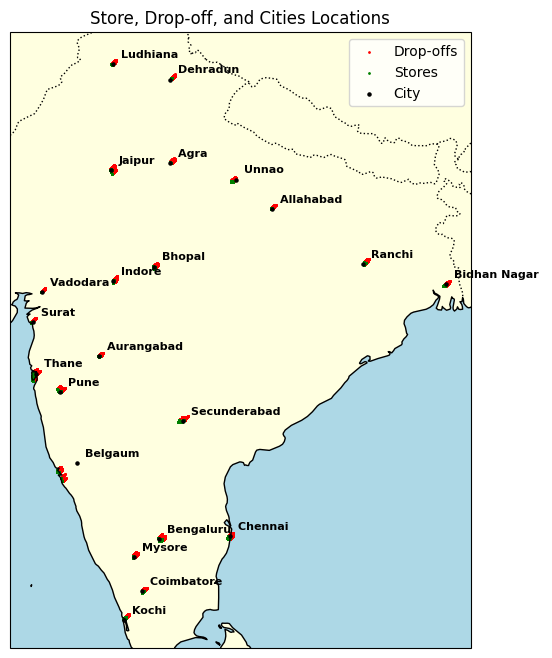

In [27]:
# Select data and remove duplicates
dfClustersCities = dfClusters[['City', 'State', 'Population',	'Latitude',	'Longitude']]
dfClustersCities = dfClustersCities.drop_duplicates(ignore_index=True)

# Map Visualization with Stores, Drop-offs, and Cluster Centers
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add basic map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Plot cluster centers in black
ax.scatter(
    dfClustersCities['Longitude'],
    dfClustersCities['Latitude'],
    color='black',
    s=5,
    label='City'
)

# Optionally, add city names as text labels
label_offset = 0.1  # degrees latitude
for idx, row in dfClustersCities.iterrows():
    ax.text(
        row['Longitude'] + 3 * label_offset,
        row['Latitude'] + 2.5 * label_offset,
        row['City'],
        fontsize=8,
        color='black',
        weight='bold'
    )

# Add title and legend
plt.title('Store, Drop-off, and Cities Locations')
plt.legend(loc='upper right')

# Show the map
plt.show()


The map visualization indicates that the **DBSCAN algorithm**, computed using Haversine distance and a Ball Tree structure, performed well in identifying clusters based on geographic coordinates. This clustering enabled the **assignment of the nearest cities** to each data point.

However, it is important to acknowledge **limitations** in the **city reference dataset**, which led to some **misclassifications**. Due to the absence of cities located closer to certain observed data points, the city of **Belgaum** was incorrectly assigned as the nearest city to a coastal region in India. This error is primarily attributable to **insufficient geographic coverage** in the **city dataset** rather than to the clustering methodology itself.

DBSCAN is an **unsupervised learning technique** that groups observations based on density and assigns proximity using distance-based criteria. While the overall clustering results were satisfactory, their accuracy remains constrained by the **quality and completeness of the geographic data**. This outcome highlights the strong dependency on high-quality, well-distributed reference data when geographic datasets are used for enrichment and spatial inference.


# Flow Classification

In [28]:
# Extract Cluster Coordinates
dfClusterMerge = pd.DataFrame({
    'Latitude': coords[:, 0].astype('float64'),
    'Longitude': coords[:, 1].astype('float64'),
    'Cluster': cluster_labels.astype('int64')
})

# Identify Store Cluster
dfDeliveryCluster = pd.merge(dfDelivery, dfClusterMerge, left_on=['Store_Latitude','Store_Longitude'], right_on=['Latitude','Longitude'], how='inner')
dfDeliveryCluster.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'Cluster': 'Cluster_Store'})

# Identify Drop Cluster
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusterMerge, left_on=['Drop_Latitude','Drop_Longitude'], right_on=['Latitude','Longitude'], how='inner')
dfDeliveryCluster.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'Cluster': 'Cluster_Drop'})

# Identify Store City
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusters, left_on=['Cluster_Store'], right_on='Cluster', how='inner')
dfDeliveryCluster.drop(['Center', 'Cluster'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'City': 'City_Store', 'Population': 'Population_Store', 'State': 'State_Store'})

# Identify Drop City
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusters, left_on=['Cluster_Drop'], right_on='Cluster', how='inner')
dfDeliveryCluster.drop(['Center', 'Cluster'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'City': 'City_Drop', 'Population': 'Population_Drop', 'State': 'State_Drop'})

# Remove Cluster
dfDeliveryCluster.drop(['Cluster_Store', 'Cluster_Drop'], axis=1, inplace=True)
dfDeliveryCluster

# Function to classify the type of delivery flow based on store and drop-off locations
def flowType(cityStore, stateStore, cityDrop, stateDrop):
  if stateStore != stateDrop:
    return 'Interstate'
  elif cityStore == cityDrop:
    return 'Intramunicipal'
  else:
    return 'Interstate'

# Apply the flowType function to each row of the DataFrame
dfDeliveryCluster['Flow_Type'] = dfDeliveryCluster.apply(
    lambda row: flowType(row['City_Store'], row['State_Store'], row['City_Drop'], row['State_Drop']),
      axis=1)

# Display DataFrame
dfDeliveryCluster

,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Dist_Euclidiana,City_Store,State_Store,Population_Store,Latitude_x,Longitude_x,City_Drop,State_Drop,Population_Drop,Latitude_y,Longitude_y,Flow_Type
0,22.745049,75.892471,22.765049,75.912471,0.028284,Indore,MADHYA PRADESH,1960631,22.719569,75.857726,Indore,MADHYA PRADESH,1960631,22.719569,75.857726,Intramunicipal
1,12.913041,77.683237,13.043041,77.813237,0.183848,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Intramunicipal
2,12.914264,77.678400,12.924264,77.688400,0.014142,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Intramunicipal
3,11.003669,76.976494,11.053669,77.026494,0.070711,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Intramunicipal
4,12.972793,80.249982,13.012793,80.289982,0.056569,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Intramunicipal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40229,23.371292,85.327872,23.481292,85.437872,0.155563,Ranchi,JHARKHAND,1073440,23.344100,85.309562,Ranchi,JHARKHAND,1073440,23.344100,85.309562,Intramunicipal
40230,26.902328,75.794257,26.912328,75.804257,0.014142,Jaipur,RAJASTHAN,3073350,26.912434,75.787271,Jaipur,RAJASTHAN,3073350,26.912434,75.787271,Intramunicipal
40231,13.022394,80.242439,13.052394,80.272439,0.042426,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Intramunicipal
40232,11.001753,76.986241,11.041753,77.026241,0.056569,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Intramunicipal


# Flow Type Distribution

In [29]:
# Display the count of each flow type in the DataFrame
dfDeliveryCluster['Flow_Type'].value_counts()

Flow_Type
Intramunicipal    40234
Name: count, dtype: int64

This time, we got lucky and were handed a dataset that contained **only intramunicipal flows**.  

With that, we wrap up our analysis. However, things could look different if the same algorithm were applied to another dataset with more diverse flows.

Feel free to take the code and give it a spin with your own data to explore how the classifications could change!

Last but not least, we save the enriched dataset from this study.

##Concentração de Mercado (Volume de entregas por Estado)

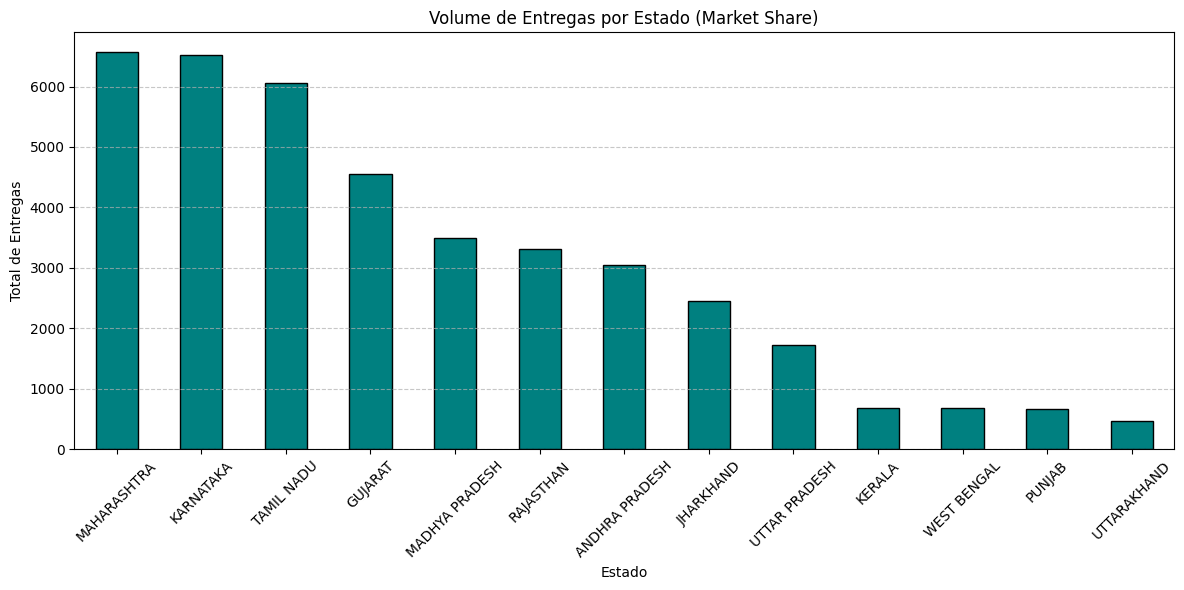

In [30]:
state_counts = dfDeliveryCluster['State_Store'].value_counts()

plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Volume de Entregas por Estado (Market Share)')
plt.xlabel('Estado')
plt.ylabel('Total de Entregas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Garante que os nomes dos estados não sejam cortados
plt.show()

A análise do mercado demonstra um domínio claro dos hubs econômicos, com uma concentração estratégica de volume de entregas nos estados de Maharashtra e Karnataka, que lideram o ranking com mais de 6.000 registros cada. Esse protagonismo é reflexo direto da presença de Mumbai, o maior centro financeiro do país, e Bengaluru, o principal polo tecnológico conhecido como o "Vale do Silício" indiano. Tamil Nadu consolida-se como o terceiro maior mercado, reafirmando a relevância do eixo sul e oeste na malha de distribuição, enquanto volumes menores em estados como Kerala, West Bengal e Punjab sugerem tanto áreas de oportunidade para expansão quanto uma estratégia deliberadamente focada em zonas de altíssima densidade urbana.

Essa distribuição espacial valida a eficácia da estratégia de Last-Mile, evidenciada pelo cruzamento entre o volume estadual e a distância geográfica das operações. A concentração massiva de entregas com deslocamento próximo a zero indica uma rede altamente capilarizada, onde as unidades de saída estão posicionadas dentro dos grandes centros consumidores para otimizar o tempo de resposta. É importante notar que os outliers de distância identificados anteriormente foram isolados como ruídos técnicos, garantindo que a análise por estado reflita a realidade operacional e não distorções de sistema.

Por fim, observa-se uma sinergia demográfica precisa entre a infraestrutura logística e a população das cidades de referência. O fato de as capitais e metrópoles com populações entre 8 e 12 milhões de habitantes estarem situadas nos estados líderes de volume comprova que a rede logística está perfeitamente alinhada à densidade populacional. Essa harmonia permite o domínio dos fluxos intramunicipais, convertendo a massa demográfica em eficiência operacional e entregas mais ágeis, fundamentadas em uma base de dados agora devidamente saneada.

#Relação População vs. Demanda
Podemos cruzar o atributo Population que você extraiu com o volume de entregas. Cidades maiores geram proporcionalmente mais entregas ou existem "cidades dormitório" com alta demanda e poucas lojas?

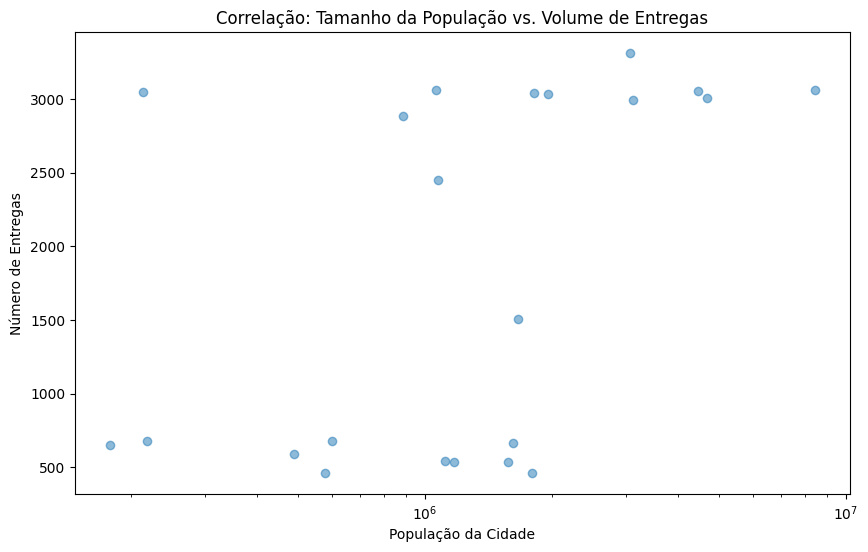

In [31]:
# Agrupando por cidade para ver a correlação
city_analysis = dfDeliveryCluster.groupby('City_Store').agg({
    'Population_Store': 'first',
    'City_Store': 'count'
}).rename(columns={'City_Store': 'Delivery_Count'})

plt.figure(figsize=(10, 6))
plt.scatter(city_analysis['Population_Store'], city_analysis['Delivery_Count'], alpha=0.5)
plt.title('Correlação: Tamanho da População vs. Volume de Entregas')
plt.xlabel('População da Cidade')
plt.ylabel('Número de Entregas')
plt.xscale('log') # Escala log para lidar com metrópoles
plt.show()

A análise do gráfico de dispersão sob escala logarítmica revela uma característica fundamental para o planejamento estratégico: a não linearidade da demanda frente ao tamanho populacional. Um dado de destaque é a formação de um cluster significativo de cidades de médio porte, com populações entre $10^5$ e $10^6$ habitantes, que já registram volumes de entrega superiores a 3.000 pedidos. Esse desempenho, que rivaliza diretamente com o de grandes metrópoles, sugere que a penetração do serviço atingiu um estágio de alta eficiência em centros urbanos secundários.Entretanto, o dataset também expõe uma alta variabilidade operacional, onde cidades com perfis demográficos similares apresentam volumes de entrega drasticamente distintos, variando de 500 a mais de 3.000 registros. Essa disparidade indica que o sucesso logístico não depende exclusivamente do contingente populacional, mas é fortemente condicionado por fatores estruturais, como a qualidade da infraestrutura local e a proximidade estratégica de centros de distribuição.

In [ ]:
# Saving Enriched Data
dfDeliveryCluster.to_csv('/content/drive/MyDrive/Portfólio/Rede delivery/delivery_enrich.csv')